In [2]:
import requests
from bs4 import BeautifulSoup
import random
import string
import nltk
import zipfile
import wikipedia
import pandas as pd
import spacy
import stanza
import ast
import seaborn as sns
import matplotlib.pyplot as plt

/Users/hzh/miniconda3/envs/data/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Collection

In [3]:
def create_dataset(src, n):
    """
    Creates a dataset of n sentences from a given source.

    src: str, either a wikipedia url or path to a zip file (ending in .zip)
    n: int, number of sentences to extract
    Return: list of strings
    """
    if "wikipedia.org" in src:
        dataset = data_from_url(src, n)
    elif src[-4:] == '.zip' and src[:4] != 'http':
      dataset = data_from_archive(n)
    else:
        raise ValueError("Invalid source specified. Please choose 'archive' or 'url'.")
    return dataset

In [4]:
def data_from_archive(path_to_zip_file, n):
    '''
    Code to retrieve data from a zip file

    path_to_zip_file: str, path to a zip file, ending in .zip
    n: int, number of sentences to extract
    Return: list of strings
    '''
    dataset = []
    count = 0

    with zipfile.ZipFile(path_to_zip_file, 'r') as f:
      for name in f.namelist():
          data = f.read(name)
          if count < n:
            dataset.append(data)
            count += 1
          else:
            break

    return dataset

def data_from_url(path_to_url, n):
    '''
    Code to retrieve data from a wikipedia url

    path_to_url: str, url to a wikipedia page
    n: int, number of sentences to extract
    Return: list of strings
    '''  
    dataset = []
    count = 0

    page = wikipedia.page(path_to_url)
    content = page.content
    dataset.append(content)
    
    all_links = page.links
    for link in all_links:
      if count < n-1:
        try:
          page = wikipedia.page(title=link)
          content = page.content
          dataset.append(content)
          count += 1
        except: pass
      else:
        break
    
    return dataset

In [5]:
src = "https://en.wikipedia.org/wiki/List_of_philosophers_born_in_the_15th_and_16th_centuries"
n = 50

# Extract data
dataset = create_dataset(src, n)

/Users/hzh/miniconda3/envs/data/lib/python3.9/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /Users/hzh/miniconda3/envs/data/lib/python3.9/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [11]:
df = pd.DataFrame(dataset, columns=['texts'])
df.to_csv('part2_dataset.csv', index=False)

# POS tagging

In [11]:
df = pd.read_csv('tokenization_after_segmentation.csv')
df.head()

,shared_sentences,tokens_stanza,tokens_spacy,cleaned_tokens_stanza,cleaned_tokens_spacy,tokens_occurence_stanza,tokens_occurence_spacy
0,"Meanwhile, the war created employment for arms...","['Meanwhile', ',', 'the', 'war', 'created', 'e...","['Meanwhile', ',', 'the', 'war', 'created', 'e...","['meanwhile', 'war', 'created', 'employment', ...","['meanwhile', 'war', 'created', 'employment', ...","Counter({'meanwhile': 1, 'war': 1, 'created': ...","Counter({'meanwhile': 1, 'war': 1, 'created': ..."
1,"As for the state debts, Hamilton suggested con...","['As', 'for', 'the', 'state', 'debts', ',', 'H...","['As', 'for', 'the', 'state', 'debts', ',', 'H...","['state', 'debt', 'hamilton', 'suggested', 'co...","['state', 'debt', 'hamilton', 'suggested', 'co...","Counter({'debt': 3, 'national': 2, 'state': 1,...","Counter({'debt': 3, 'national': 2, 'state': 1,..."
2,== External links ==\nAndrew Ducarel Record at...,"['==', 'External', 'links', '==', 'Andrew', 'D...","['=', '=', 'External', 'links', '=', '=', '\n'...","['external', 'link', 'andrew', 'ducarel', 'rec...","['external', 'link', 'andrew', 'ducarel', 'rec...","Counter({'external': 1, 'link': 1, 'andrew': 1...","Counter({'external': 1, 'link': 1, 'andrew': 1..."
3,"Some individual slaveholders, particularly in ...","['Some', 'individual', 'slaveholders', ',', 'p...","['Some', 'individual', 'slaveholders', ',', 'p...","['individual', 'slaveholder', 'particularly', ...","['individual', 'slaveholder', 'particularly', ...","Counter({'individual': 1, 'slaveholder': 1, 'p...","Counter({'individual': 1, 'slaveholder': 1, 'p..."
4,Hamilton was prepared to march the army throug...,"['Hamilton', 'was', 'prepared', 'to', 'march',...","['Hamilton', 'was', 'prepared', 'to', 'march',...","['hamilton', 'prepared', 'march', 'army', 'sou...","['hamilton', 'prepared', 'march', 'army', 'sou...","Counter({'hamilton': 1, 'prepared': 1, 'march'...","Counter({'hamilton': 1, 'prepared': 1, 'march'..."


In [12]:
# to be deleted
df['cleaned_tokens_stanza'] = df['cleaned_tokens_stanza'].apply(ast.literal_eval)
df['cleaned_tokens_spacy'] = df['cleaned_tokens_spacy'].apply(ast.literal_eval)

In [13]:
# to be deleted
# creating vocabularies of unique tokens for each library
vocab_stanza = set(token for tokens in df['cleaned_tokens_stanza'] for token in tokens)
vocab_spacy = set(token for tokens in df['cleaned_tokens_spacy'] for token in tokens)

# tokens which simalteneously present in both vocabularies
SharedTokenInSentences = vocab_stanza.intersection(vocab_spacy)

# creating dataframe for storing pos tags
df_pos = pd.DataFrame(columns=['token', 'stanza_pos', 'spacy_pos'])
df_pos['token'] = list(SharedTokenInSentences)

In [14]:
# pos tagging using stanza
nlp_stanza = stanza.Pipeline(lang='en', processors='tokenize,pos')
stanza_doc = df_pos['token'].apply(nlp_stanza)
df_pos['stanza_pos'] = [token.sentences[0].words[0].upos for token in stanza_doc]

2023-05-14 15:55:03 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2023-05-14 15:55:04 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |

2023-05-14 15:55:04 INFO: Using device: cpu
2023-05-14 15:55:04 INFO: Loading: tokenize
2023-05-14 15:55:04 INFO: Loading: pos
2023-05-14 15:55:04 INFO: Done loading processors!


In [15]:
# pos tagging using spacy
nlp_spacy = spacy.load('en_core_web_sm')
df_pos['spacy_pos'] = [t.pos_ for token in df_pos['token'].apply(nlp_spacy) for t in token]

In [16]:
df_pos.head()

,token,stanza_pos,spacy_pos
0,thrill,NOUN,NOUN
1,protestors,NOUN,NOUN
2,horen,NOUN,NOUN
3,act,VERB,VERB
4,wonder,VERB,VERB


In [17]:
print(f"Number of tokens in the dataset: {df_pos.shape[0]}")
print(f"Number of times the token is assigned the same UPOS by both libraries: {df_pos[df_pos['stanza_pos'] == df_pos['spacy_pos']].shape[0]}")
print(f"Ratio of the times the token is assigned the same UPOS by both libraries: {df_pos[df_pos['stanza_pos'] == df_pos['spacy_pos']].shape[0] / df_pos.shape[0]}")

Number of tokens in the dataset: 10984
Number of times the token is assigned the same UPOS by both libraries: 7501
Ratio of the times the token is assigned the same UPOS by both libraries: 0.6829024034959942


In [18]:
# list of pos tags in each library's results
upos_spacy = df_pos['spacy_pos'].unique()
upos_stanza = df_pos['stanza_pos'].unique()

In [19]:
def frequency_mapping(lib, upos_list):
    '''
    Map frequency of UPOS tags in one library to the other library
    lib: str, 'spacy' or 'stanza'
    upos_list: list of UPOS tags in the library
    return: dict, mapping of frequencies
    '''
    if lib == 'spacy':
        other_lib = 'stanza'
    else:
        other_lib = 'spacy'

    print(f"Frequencies of {lib} UPOS tags")
    mapping = {}
    for tag in upos_list:
        print(f"\nFor all tokens labelled {tag} in {lib}:")

        mapping[tag] = {}
        sub_df = df_pos[df_pos[f'{lib}_pos'] == tag]
        other_lib_tag_list = df_pos[df_pos[f'{lib}_pos'] == tag][f'{other_lib}_pos'].unique()

        for other_tag in other_lib_tag_list:
            mapping[tag][other_tag] = len(sub_df[sub_df[f'{other_lib}_pos'] == other_tag]) / len(sub_df) * 100
        for key, value in mapping[tag].items():
            print(f"{key}: {value:.2f}%", end=", ")

    return mapping

In [20]:
mapping_spacy = frequency_mapping('spacy', upos_spacy)

Frequencies of spacy UPOS tags

For all tokens labelled NOUN in spacy:
NOUN: 71.70%, PROPN: 22.50%, VERB: 2.26%, ADJ: 2.92%, X: 0.32%, INTJ: 0.22%, ADV: 0.07%, NUM: 0.02%, 
For all tokens labelled VERB in spacy:
VERB: 59.82%, PROPN: 11.20%, ADJ: 5.87%, NOUN: 22.79%, INTJ: 0.09%, X: 0.15%, PUNCT: 0.03%, SYM: 0.03%, ADV: 0.03%, 
For all tokens labelled PROPN in spacy:
PROPN: 72.25%, INTJ: 0.92%, NOUN: 20.63%, ADJ: 4.30%, VERB: 1.29%, X: 0.37%, ADV: 0.18%, PUNCT: 0.06%, 
For all tokens labelled ADJ in spacy:
ADJ: 79.70%, NOUN: 8.97%, PROPN: 8.80%, VERB: 1.48%, ADV: 0.87%, INTJ: 0.17%, 
For all tokens labelled INTJ in spacy:
PROPN: 40.00%, INTJ: 28.00%, NOUN: 28.00%, ADJ: 4.00%, 
For all tokens labelled ADP in spacy:
ADP: 20.00%, ADV: 42.50%, NOUN: 5.00%, PROPN: 30.00%, ADJ: 2.50%, 
For all tokens labelled ADV in spacy:
ADV: 68.75%, CCONJ: 0.20%, PROPN: 13.48%, ADJ: 10.35%, NOUN: 6.25%, INTJ: 0.78%, SYM: 0.20%, 
For all tokens labelled PRON in spacy:
PRON: 57.89%, NOUN: 15.79%, PROPN: 15.7

In [21]:
mapping_stanza = frequency_mapping('stanza', upos_stanza)

Frequencies of stanza UPOS tags

For all tokens labelled NOUN in stanza:
NOUN: 69.95%, PROPN: 7.96%, VERB: 18.42%, ADJ: 2.44%, ADP: 0.05%, PRON: 0.07%, ADV: 0.76%, X: 0.12%, NUM: 0.02%, INTJ: 0.17%, PUNCT: 0.05%, 
For all tokens labelled VERB in stanza:
VERB: 93.92%, NOUN: 4.28%, PROPN: 0.97%, ADJ: 0.78%, X: 0.05%, 
For all tokens labelled PROPN in stanza:
PROPN: 43.67%, NOUN: 34.36%, VERB: 14.17%, INTJ: 0.37%, ADJ: 3.75%, ADV: 2.56%, X: 0.37%, ADP: 0.45%, PUNCT: 0.11%, PRON: 0.11%, CCONJ: 0.04%, AUX: 0.04%, 
For all tokens labelled ADJ in stanza:
ADJ: 67.18%, VERB: 14.68%, PROPN: 5.14%, NOUN: 8.81%, ADV: 3.89%, X: 0.15%, ADP: 0.07%, INTJ: 0.07%, 
For all tokens labelled INTJ in stanza:
PROPN: 35.71%, INTJ: 16.67%, VERB: 7.14%, NOUN: 21.43%, ADJ: 4.76%, ADV: 9.52%, PUNCT: 2.38%, X: 2.38%, 
For all tokens labelled ADP in stanza:
ADP: 61.54%, SCONJ: 38.46%, 
For all tokens labelled ADV in stanza:
ADP: 4.31%, ADV: 89.34%, ADJ: 2.54%, PROPN: 0.76%, SCONJ: 1.52%, X: 0.25%, NOUN: 0.76%, AUX:

## Visualization

In [22]:
spacy2stanza = pd.DataFrame(mapping_spacy)
stanza2spacy = pd.DataFrame(mapping_stanza)

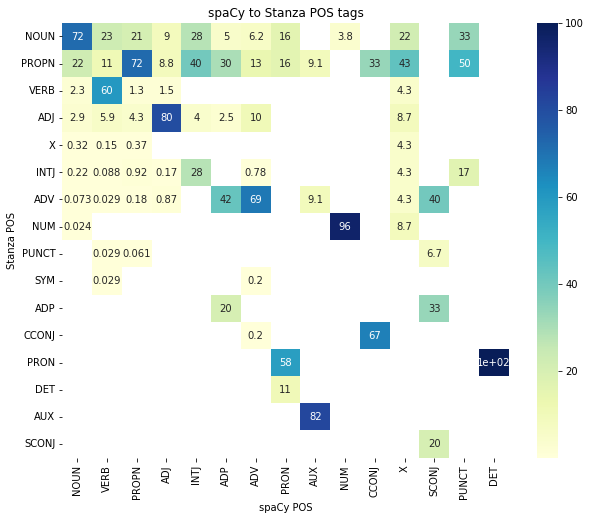

In [26]:
plt.figure(figsize=(10, 8))
sns.heatmap(spacy2stanza, annot=True, cmap='YlGnBu')
plt.title('spaCy to Stanza POS tags')
plt.xlabel('spaCy POS')
plt.ylabel('Stanza POS')
plt.show()

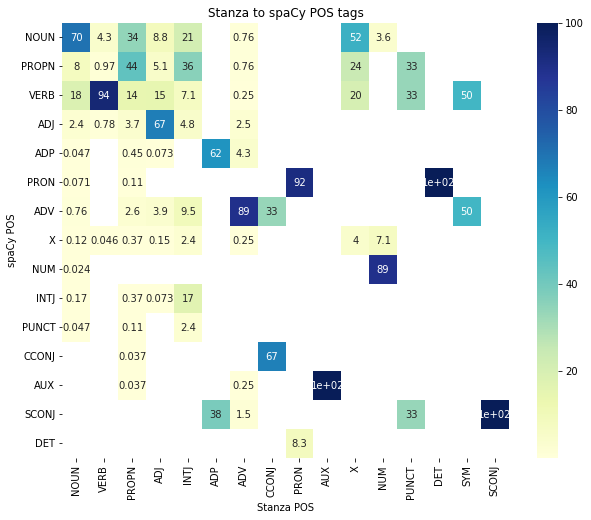

In [27]:
plt.figure(figsize=(10, 8))
sns.heatmap(stanza2spacy, annot=True, cmap='YlGnBu')
plt.title('Stanza to spaCy POS tags')
plt.xlabel('Stanza POS')
plt.ylabel('spaCy POS')
plt.show()